In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.stats import bayesian_blocks
%matplotlib inline

import cosmology
from hbtp import HBTReader

from src.prof import HBTProfileReader
from src.cmh import HBTHistoryReader
from src import read

In [2]:
plt.style.use('paper')

### Analysis parameters

In [3]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
NFW_f = 0.02
# nbins = 20
bin = 9

r = HBTReader("./data/%s/subcat" % grav)
prof_reader = HBTProfileReader("./data/%s/subcat" % grav)
hist_reader = HBTHistoryReader("./data/%s/subcat" % grav)

zs = pd.read_csv(
    "./data/redshift_list.txt", delimiter=" ", header=None, names=["snap", "z"]
).set_index("snap")

### Subhalo mass function

In [4]:
# def subhalo_mass_function(r, snap):
#     ss = r.LoadSubhalos(snap)
#     ss = ss[
#         (ss["HostHaloId"] != -1) & (ss["BoundM200Crit"] > 0.0) & (ss["Nbound"] >= 20)
#     ]

#     counts, bin_edges = np.histogram(np.log10(ss["Nbound"]), 20)
#     ss = np.lib.recfunctions.append_fields(
#         ss, "bin", np.digitize(np.log10(ss["BoundM200Crit"]), bin_edges), usemask=False
#     )
#     bins = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#     return bins, np.log10(counts)

### Halo mass function & binning

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [5]:
def read_haloes(r, snap):
    hs = r.LoadHostHalos(snap)
    hs = hs[np.sum(hs["Profile"], axis=1) >= 1000]
#     hs = hs[hs["M200Crit"] >= 20]
#     hs = hs[hs["CenterOffset"] >= 0.07]
    hs["M200Crit"] = 1e10 * hs["M200Crit"]
    return hs[["HaloId", "M200Crit"]]


def bin_haloes(haloes, bin_column, bin_edges, bin_transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(
        haloes,
        "bin",
        np.digitize(bin_transform(haloes[bin_column]), bin_edges, right=True),
        usemask=False,
    )
    return hs

In [6]:
hs = read_haloes(r, snap)

In [7]:
bin_edges = bayesian_blocks(np.log10(hs['M200Crit']))
bin_counts, bin_edges = np.histogram(np.log10(hs["M200Crit"]), bin_edges)

In [8]:
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
nbins = bin_edges.size - 1

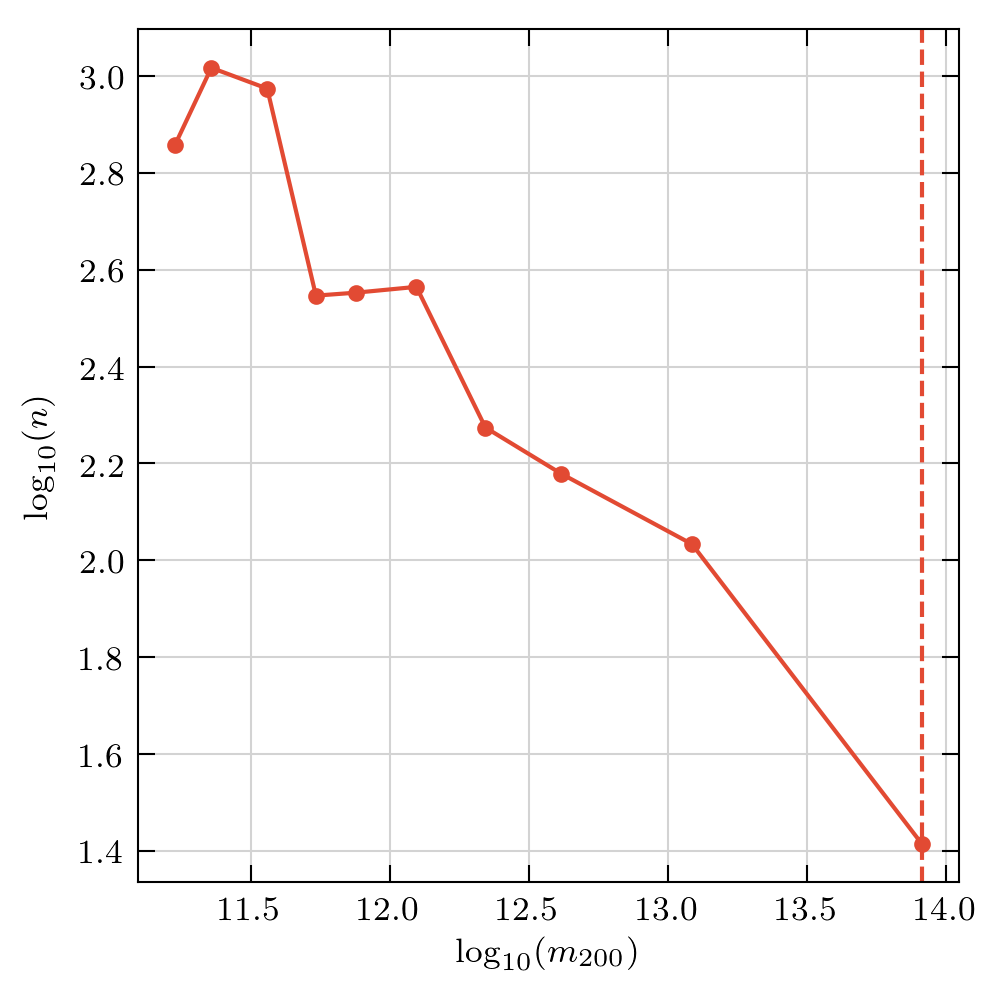

In [9]:
fig, ax = plt.subplots(1)
ax.set_xlabel(r"$\log_{10}(m_{200})$")
ax.set_ylabel(r"$\log_{10}(n)$")

# bin_counts = counts / 64**3
# bin_counts = counts / 0.15
bin_counts = np.log10(bin_counts)

ax.axvline(bin_centres[bin], color='C0', linestyle='--')
ax.plot(bin_centres, bin_counts, color='C0', marker='.')

fig.tight_layout()

### $M^*$ calculation

In [10]:
# fig, ax = plt.subplots(1)
# ax.set_xlabel(r"$\log_{10}(m_{200})$")
# ax.set_ylabel(r"$\log_{10}(n)$")

# n_star = 1.5
# m_star = []
# ax.axhspan(0.0, n_star, color="lightgrey", alpha=0.5)

# for i, _snap in enumerate([51, 61, 78, 93, 122]):
#     x_k, y_k = halo_mass_function(r, _snap, nbins)
#     y1, y2 = y_k[y_k > n_star][-1], y_k[y_k < n_star][0]
#     x1, x2 = x_k[y_k > n_star][-1], x_k[y_k < n_star][0]
# #     print(len(y_k[y_k > n_star]))
#     m_star.append(((x2 - x1) / (y2 - y1)) * (n_star - y1) + x1)

#     ax.plot(x_k, y_k, "C%d" % i, label="%.1f" % (zs.loc[_snap].values[0]))
#     ax.axvline(m_star[i], ls="--", color="C%d" % i)

# ax.legend(title="z")
# ax.set_ylim([0.0, 3.0])

# fig.tight_layout()

# # fig.savefig("./plots/mf_mstar.pdf")

Health check: is $M^{*}$ following $(1+z)^2$ relation?

In [11]:
# plt.plot(
#     zs.loc[[51, 61, 78, 93, 122]].values,
#     m_star,
# )
# plt.ylabel(r"$M^{*}$")
# plt.xlabel("z")

# plt.tight_layout()

### Keep only one bin

Only keep haloes in each bin for individual bin plots:

In [12]:
hs = hs[hs['bin'] == bin]

### Density profile

In [13]:
def read_profiles(ids, snap=snap):
    return np.array(prof_reader.GetHostProfile([ids], snap), dtype=float)

In [14]:
def halo_profiles(r, ids, prof):
    ps = read_profiles(ids)
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    if prof == "nfw":

        def f(x, c):
            return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

        fit = curve_fit(
            f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx]
        )
        c = fit[0][0]

        rho_s = np.log10(cosmology.nfw.rho_enc(1.0 / c, c))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c

    elif prof == "einasto":

        def f(x, c, a):
            return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

        fit = curve_fit(
            f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx]
        )
        c, a = fit[0][0], fit[0][1]

        rho_s = np.log10(cosmology.einasto.rho_enc(1.0 / c, c, a))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c, a

    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")


c = halo_profiles(prof_reader, list(hs["HaloId"]), prof)[5]

INFO:root:Retrieving profile for halos [[19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 132, 136, 138, 140, 141, 142, 143, 144, 147, 150, 153, 154, 166]]


In [15]:
c

6.8677796621934615

In [16]:
def fit_nfw(ids, snap=snap):
    ps = read_profiles(ids, snap)
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c):
        return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

    popt, pcov = curve_fit(
        f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(x[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 1 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 1 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt


def fit_einasto(ids, snap=snap):
    ps = read_profiles(ids, snap)
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c, a):
        return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

    popt, pcov = curve_fit(
        f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(x[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 2 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 2 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt

In [17]:
fit_nfw(list(hs['HaloId']))

INFO:root:Retrieving profile for halos [[19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 132, 136, 138, 140, 141, 142, 143, 144, 147, 150, 153, 154, 166]]


(0.9903134984602092,
 2.0194674417399865,
 2.7920561639797676,
 0.009733720869993207,
 array([6.86777966]))

In [18]:
fit_einasto(list(hs['HaloId']))

INFO:root:Retrieving profile for halos [[19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 132, 136, 138, 140, 141, 142, 143, 144, 147, 150, 153, 154, 166]]
/cosma/home/dp004/dc-oles1/src/cosmology/cosmology/einasto/__init__.py:7: RuntimeWarning: invalid value encountered in power
  return gammainc(3.0 / a, (2.0 / a) * np.power(u, a))


(0.9995060715896268,
 4.000988100866385,
 5.546165545345947,
 0.0004940504331925086,
 array([6.06607838, 0.18168048]))

In [19]:
halo_profiles(prof_reader, list(hs['HaloId']), 'einasto')[5:]

INFO:root:Retrieving profile for halos [[19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 132, 136, 138, 140, 141, 142, 143, 144, 147, 150, 153, 154, 166]]


(6.066078381358315, 0.18168048132041975)

INFO:root:Retrieving profile for halos [[19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 132, 136, 138, 140, 141, 142, 143, 144, 147, 150, 153, 154, 166]]


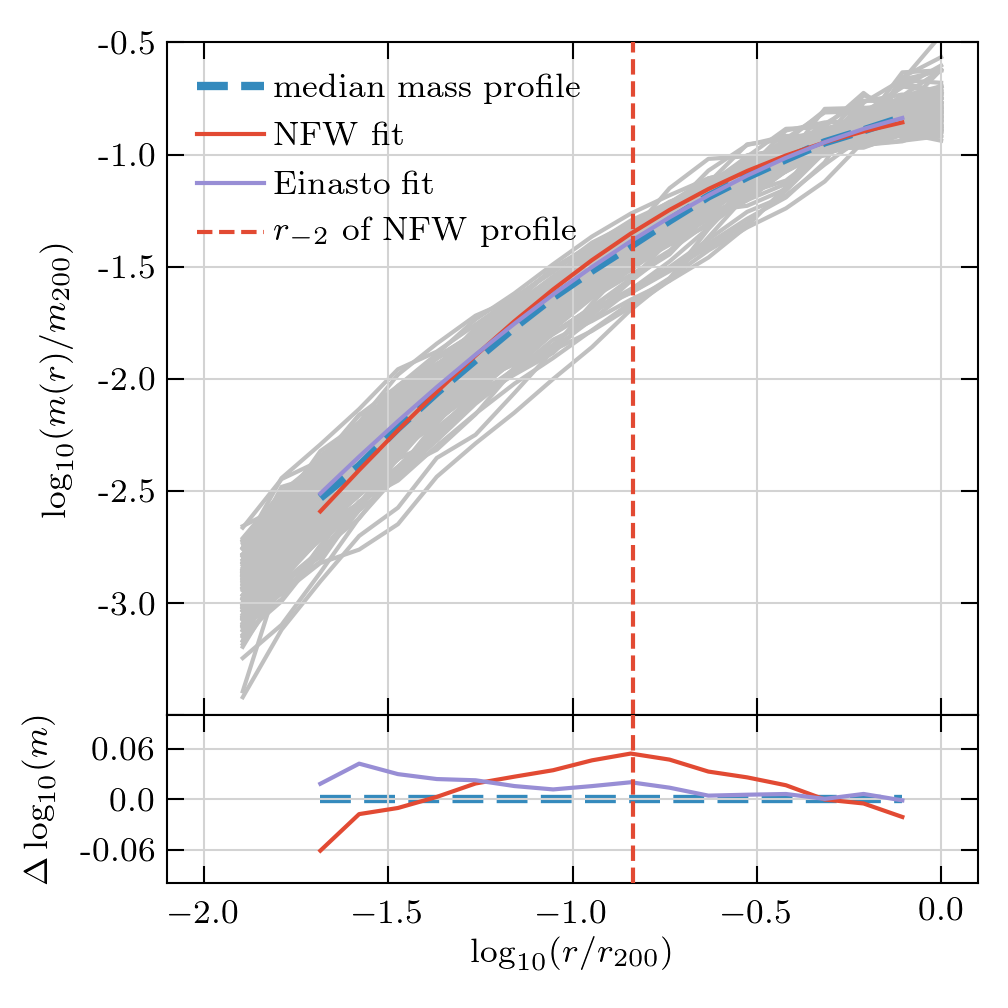

In [20]:
fig = plt.figure()
grid = plt.GridSpec(5, 1, hspace=0.0, wspace=0.0)

ax = fig.add_subplot(grid[:-1, 0])
ax.set_xlabel(None)
ax.set_ylabel(r"$\log_{10}(m(r) / m_{200})$")
ax.set_xlim([-2.1, 0.1])
ax.set_ylim([-3.5, -0.5])
ax.set_yticklabels([None, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])

ax_res = fig.add_subplot(grid[-1, 0], yticklabels=[], sharex=ax)
ax_res.set_xlabel(r"$\log_{10}(r / r_{200})$")
ax_res.set_ylabel(r"$\Delta\log_{10}(m)$")
ax_res.set_ylim([-0.1, 0.1])
ax_res.set_yticks([-0.06, 0.0, 0.06])
ax_res.set_yticklabels([-0.06, 0.0, 0.06])

if prof == 'nfw':
    ps, x, p, idx, rho_s, c = halo_profiles(prof_reader, list(hs['HaloId']), prof)
elif prof == 'einasto':
    ps, x, p, idx, rho_s, c, a = halo_profiles(prof_reader, list(hs['HaloId']), prof)
else:
    raise ValueError("Profile must be either 'nfw' or 'einasto'")

for _p in ps:
    ax.plot(x[1:], _p[1:], color='silver', zorder=0)
#     ax_res.plot(x[1:], (_p - p)[1:], color='silver', zorder=0)

ax.plot(x[idx], p[idx], color='C1', linestyle='--', linewidth=2, zorder=2, label='median mass profile')
ax_res.plot(x[idx], np.zeros_like(p[idx]), color='C1', linestyle='--', linewidth=2, zorder=1)

ax.plot(x[idx], np.log10(cosmology.nfw.m_diff(np.power(10.,x), c)[idx]),
    color='C0', linestyle='-', linewidth=1, zorder=3, label='NFW fit')
ax_res.plot(x[idx], np.log10(cosmology.nfw.m_diff(np.power(10.,x), c)[idx]) - p[idx],
    color='C0', linestyle='-', linewidth=1, zorder=3)

ax.plot(x[idx], np.log10(cosmology.einasto.m_diff(np.power(10.,x), 6.68849701, 0.16772251)[idx]),
    color='C2', linestyle='-', linewidth=1, zorder=3, label='Einasto fit')
ax_res.plot(x[idx], np.log10(cosmology.einasto.m_diff(np.power(10.,x), 6.68849701, 0.16772251)[idx]) - p[idx],
    color='C2', linestyle='-', linewidth=1, zorder=3)

ax.axvline(np.log10(1.0/c), color='C0', linestyle='--', zorder=4, linewidth=1, label='$r_{-2}$ of NFW profile')
ax_res.axvline(np.log10(1.0/c), color='C0', linestyle='--', zorder=4, linewidth=1)

ax.legend(loc='upper left')

fig.tight_layout()

# fig.savefig("./plots/prof_gr.pdf")

### Collapsed Mass History

In [21]:
def F(profile, *args):
    if profile == 'nfw':
        c = args[0]
        return cosmology.nfw.m(1.0/c, c)
    elif profile == 'einasto':
        c, a = args
        return cosmology.einasto.m(1.0/c, c, a)
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

In [22]:
def halo_mass_history(grav, snap, hs, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))
            .set_index('HostHaloId')
            .fillna(0.0)
            .loc[hs['HaloId']]
            .dropna(),
        dtype=float
    )
    ms = np.divide(ms.T, ms[:,-1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array([
            zs[zs['Snapshot'] == s][0]['Redshift']
            for s in np.arange(1+snap-ms.shape[1], 1+snap)
        ])) / \
        cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

    m_f = F*m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

    return ms, rho, m, rho_f

In [23]:
F(prof, c)

0.162325393639008

In [24]:
F('einasto', 6.952734560253492, 0.172666949034731)

0.16014587294413327

/cosma/home/dp004/dc-oles1/var/cosma7/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-oles1/var/cosma7/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


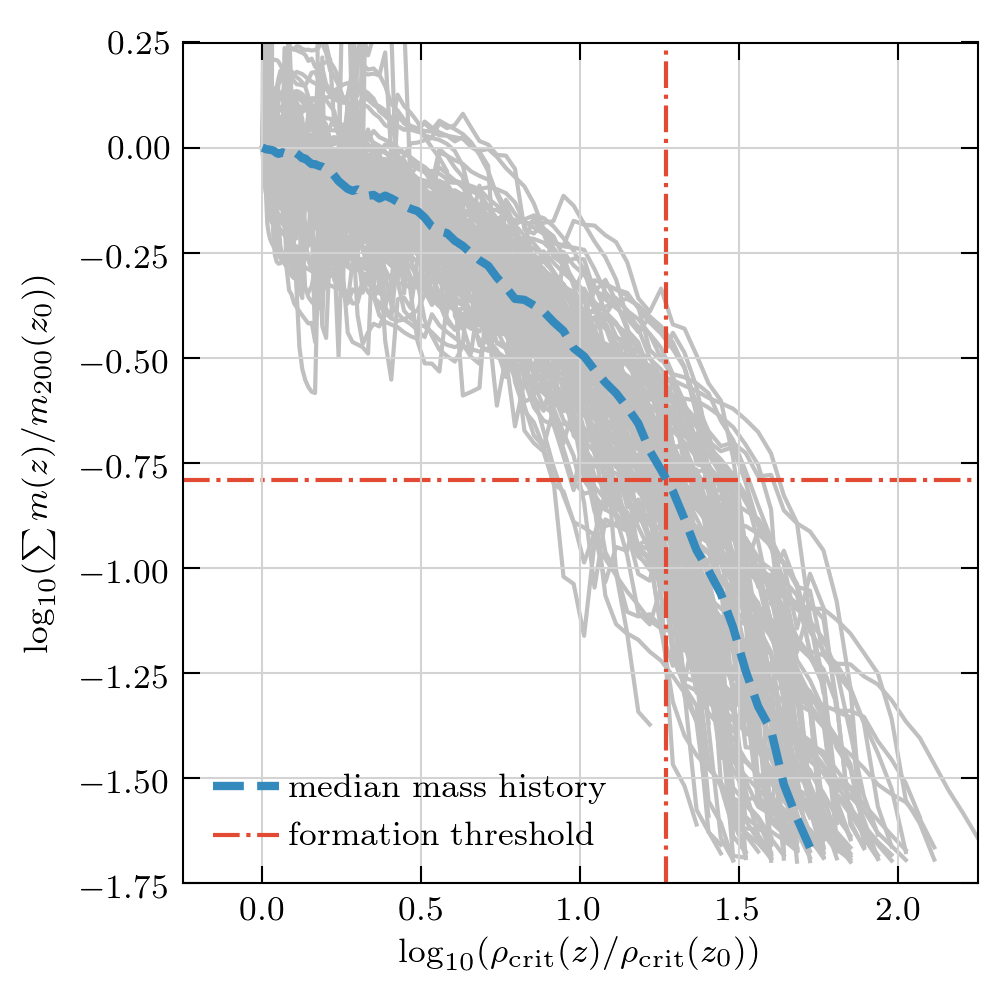

In [25]:
def plot_halo_mass_history(ax, *args):
    ms, rho, m, rho_f = args
    
    ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
    ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")
    ax.set_xlim([-0.25, 2.25])
    ax.set_ylim([-1.75, 0.25])

    [ax.plot(np.log10(rho), np.log10(_), color='silver', zorder=0) for _ in ms]
    ax.plot(np.log10(rho), np.log10(m), color='C1', linestyle='--', linewidth=2, zorder=2, label='median mass history')
    ax.axvline(rho_f, color='C0', linestyle='-.', linewidth=1, zorder=1, label='formation threshold')
    ax.axhline(np.log10(F(prof, c)), color='C0', linestyle='-.', zorder=1, linewidth=1)

# def plot_analytical_mass_profile(ax, ids, snap):
#     ys = read_profiles(ids, snap)
#     ys = np.log10(
#         np.divide(
#             ys,
#             np.repeat(ys[:,-1], ys.shape[1]).reshape(ys.shape)
#         )
#     )
#     xs = np.linspace(-2.0, 0.0, ys.shape[1])

#     ax.plot(
#         np.log10(cosmology.nfw.rho_enc(np.power(10, xs), c) / 200.0) / (200.0/cosmology.rho_0),
#         np.log10(cosmology.nfw.m(np.power(10, xs), c)),
#         c="C5", linestyle="-", label="prediction"
#     )

fig, ax = plt.subplots(1)
plot_halo_mass_history(ax, *halo_mass_history(grav, snap, hs, F(prof, c)))
# plot_analytical_mass_profile(ax, list(hs["HaloId"]), snap)
ax.legend()

fig.tight_layout()

# fig.savefig("./plots/cmh_gr.pdf")

In [26]:
# fig, ax = plt.subplots(1)
# ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
# ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")

# d = pd.read_csv("./cmh_31_8.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[31, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 31")

# d = pd.read_csv("./cmh_34_1.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[34, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 34")

# d = pd.read_csv("./cmh_70_1.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[70, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 70")

# ax.legend()

### $\delta_{\rm sc}$ calculations

In [27]:
from scipy.special import erfcinv
import cosmology

In [28]:
zs["rho"] = cosmology.rho_c(zs["z"]) / cosmology.rho_0
zs

,z,rho
snap,,
1,49.000000,35125.719000
2,30.000100,8372.071013
3,23.978100,4379.815542
4,19.915700,2571.846017
5,19.044900,2263.893295
6,18.243700,2003.216827
7,17.452900,1766.351054
8,16.724500,1565.408969
9,16.005600,1382.636761


In [29]:
rho_f = 10**halo_mass_history(grav, snap, hs, F(prof, c))[-1]
rho_f

18.64590983695554

In [30]:
z1, z2     = zs[zs["rho"] < rho_f]["z"].iloc[0], zs[zs["rho"] > rho_f]["z"].iloc[-1]
rho1, rho2 = zs[zs["rho"] < rho_f]["rho"].iloc[0], zs[zs["rho"] > rho_f]["rho"].iloc[-1]
z1, z2, rho1, rho2
z_f = ((z1 - z2) / (rho1 - rho2)) * (rho_f - rho1) + z1
z_f

2.9949021899516493

In [31]:
z_0 = zs.loc[snap]["z"]

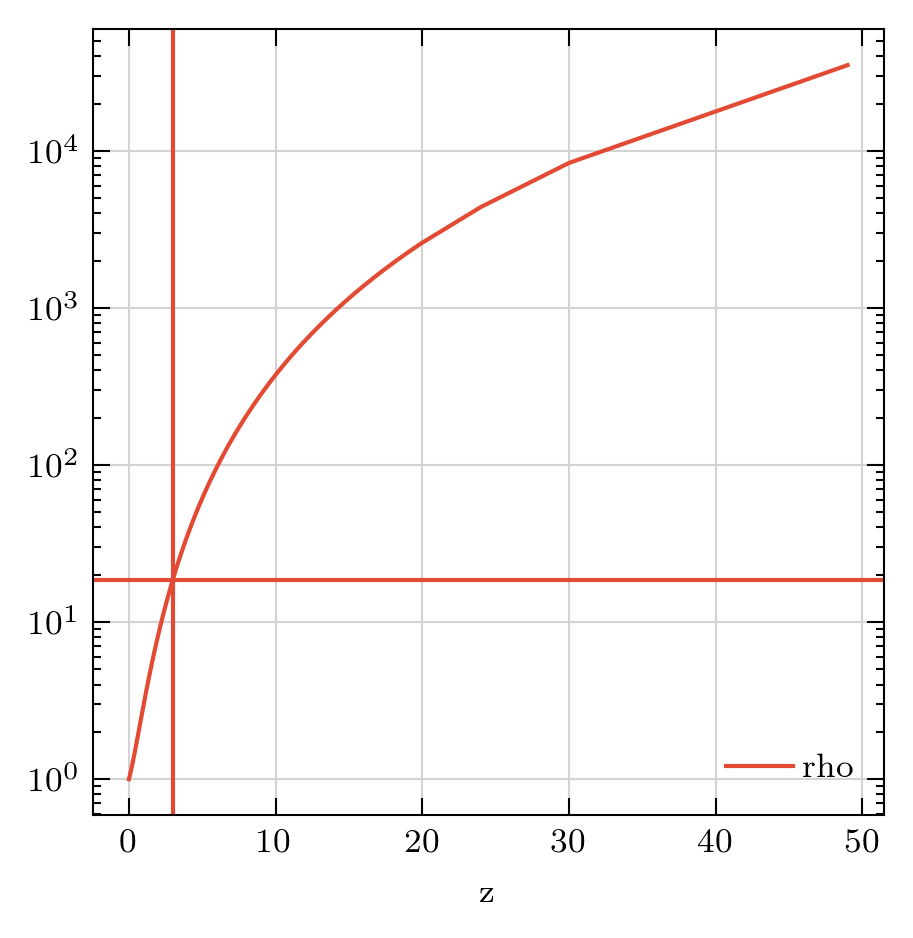

In [32]:
ax = zs.plot("z", "rho")
ax.axhline(rho_f)
ax.axvline(z_f)

ax.set_yscale("log")

In [33]:
m = np.median(hs["M200Crit"])
m

9965677000000.0

In [34]:
dd_1 = erfcinv(F(prof, c)) * \
    np.sqrt(
    2 * (cosmology.sigma(NFW_f * m, z_0)**2.0 -
         cosmology.sigma(m, z_0)**2.0)
)

dd_1

0.01447441378689943

In [35]:
dd_2 = cosmology.delta_sc(z_f) - cosmology.delta_sc(z_0)
dd_2

3.508712336032805